In [1]:
%run ../MyModule/JupyterCPP.py

# Implementation d'une structure de gestion de données avec C++

Dans le cadre de notre projet visant à lutter contre la pollution numérique, nous avons choisi d'utiliser la puissante structure de données `unordered_map` en C++ pour stocker efficacement nos informations. Explorons comment cette structure fonctionne et comment nous l'appliquons à notre projet.

## Utilisation d'`unordered_map` en C++

L'`unordered_map` est une structure de données associant des clés à des valeurs de manière efficace. Elle est basée sur le concept de table de hachage, ce qui permet un accès rapide aux éléments. Dans notre cas, nous l'utiliserons pour associer des informations de flux (`flow_info`) à des structures de flux (`flow_struct`).

```cpp
#include <unordered_map>

struct flow_info{
    int family; // AF_INET ou AF_INET6
        uint32_t src_ip; // Make union if possible
        Tins::IPv6::address_type src_ipv6;
        uint32_t dst_ip;
        Tins::IPv6::address_type dst_ipv6;
    uint16_t src_port;
    uint16_t dst_port;
    ndpi_protocol detected_protocol; 
    bool is_tcp;
};

struct flow_struct {
    flow_info info;
    ndpi_flow_struct ndpi_flow;
    std::vector<packet_struct> packets;
};

std::unordered_map<flow_info, std::unique_ptr<flow_struct>> dataMap;
```

## Rapidité de unordered_map
L'`unordered_map` offre des performances rapides en moyenne pour les opérations d'insertion, de recherche et de suppression. Grâce à son implémentation basée sur une table de hachage, l'accès aux éléments se fait en temps constant en moyenne, ce qui est crucial pour notre applicatio

## Gestion des timestamps avec une "queue" C++

Nous avons également besoin de rechercher rapidement les données par timestamp. Pour ce faire, nous créerons une file (`queue`) en C++, naturellement ordonnée par timestamp.

```cpp
#include <queue>

struct TimestampQueue {
    // Définir la structure TimestampQueue
};

std::queue<TimestampQueue> timestampQueue;
```

Chaque élément de la file sera associé à un pointeur vers notre objet dans `unordered_map`, permettant ainsi de supprimer rapidement toutes les données jusqu'au timestamp souhaité.

## Gain de temps vs Surcoût en mémoire
L'utilisation d'une `unordered_map` offre une rapidité significative pour les opérations de recherche, mais il est important de noter qu'elle peut entraîner un surcoût en mémoire à cause de la `queue` qui duplique de l'information. Nous devons évaluer attentivement ce surcoût en fonction des besoins spécifiques de notre application, en tenant compte des avantages en termes de performance.

## Intégration des structures

Maintenant, voyons comment intégrer ces structures dans notre logiciel.

```cpp
// Ajout d'un élément à unordered_map
flow_info info;
std::unique_ptr<flow_struct> flowData = std::make_unique<flow_struct>();
dataMap[info] = std::move(flowData);

// Ajout d'un élément à la file avec timestamp
TimestampQueue timestampData;
timestampData.timestamp = /* définir le timestamp */;
timestampData.pointer = &dataMap[info];
timestampQueue.push(timestampData);

// Suppression des données jusqu'au timestamp spécifié
while (!timestampQueue.empty() && timestampQueue.front().timestamp <= /* timestamp à atteindre */) {
    dataMap.erase(*timestampQueue.front().pointer);
    timestampQueue.pop();
}
```

Ainsi, notre structure de gestion de données permet d'associer des informations de flux à des structures de flux tout en facilitant la recherche et la suppression basées sur les timestamps. Cela devrait contribuer efficacement à la réalisation de notre projet de lutte contre la pollution numérique.


## Comparaison entre une `unordered_map` et une `map` et une `queue` et un `vector`

In [2]:
%%cpp
#include <iostream>
#include <fstream>
#include <unordered_map>
#include <map>
#include <vector>
#include <ctime>
#include <cstdlib>
#include <chrono>
#include <algorithm>
#include <functional>

#include <iostream>
#include <fstream>
#include <unordered_map>
#include <map>
#include <vector>
#include <ctime>
#include <cstdlib>
#include <chrono>
#include <algorithm>
#include <functional>

int main() {
    const int MIN = 1000;  // Taille min
    const int MAX = 10000;  // Taille max
    const int PAS = 100;  // Pas

    std::unordered_map<int, int> unorderedMap;
    std::map<int, int> orderedMap;
    std::vector<int> vector;

    // Fonction pour mesurer le temps
    auto measureTime = [](const std::function<void()>& func) {
        auto start = std::chrono::high_resolution_clock::now();
        func();
        auto end = std::chrono::high_resolution_clock::now();
        return std::chrono::duration_cast<std::chrono::microseconds>(end - start).count();
    };

    // Nom du fichier CSV
    const std::string csvFileName = "resultats.csv";

    // Ouverture du fichier en mode écriture
    std::ofstream csvFile(csvFileName);

    // Vérification si l'ouverture a réussi
    if (!csvFile.is_open()) {
        std::cerr << "Erreur lors de l'ouverture du fichier CSV." << std::endl;
        return 1; // Quitter le programme avec un code d'erreur
    }

    // Écriture de l'en-tête du fichier CSV
    csvFile << "Size,UnorderedMapTime,OrderedMapTime,VectorTime\n";

    // Boucle pour différentes tailles de données
    for (int size = MIN; size <= MAX; size += PAS) {
        // Remplissage des structures avec des nombres aléatoires
        unorderedMap.clear();
        orderedMap.clear();
        vector.clear();

        for (int i = 0; i < size; ++i) {
            int randomNum = rand() % size;  // Nombre aléatoire dans la plage
            unorderedMap[randomNum] = i;
            orderedMap[randomNum] = i;
            vector.push_back(randomNum);
        }

        // Mesurer le temps pour la recherche dans unordered_map
        auto unorderedMapTime = measureTime([&]() {
            for (int i = 0; i < size; ++i) {
                auto it = unorderedMap.find(i);
                // Faire quelque chose avec 'it' pour éviter l'optimisation du compilateur
                if (it != unorderedMap.end()) {}
            }
        });

        // Mesurer le temps pour la recherche dans ordered_map
        auto orderedMapTime = measureTime([&]() {
            for (int i = 0; i < size; ++i) {
                auto it = orderedMap.find(i);
                // Faire quelque chose avec 'it' pour éviter l'optimisation du compilateur
                if (it != orderedMap.end()) {}
            }
        });

        // Mesurer le temps pour la recherche dans vector
        auto vectorTime = measureTime([&]() {
            for (int i = 0; i < size; ++i) {
                auto it = std::find(std::begin(vector), std::end(vector), i);
                // Faire quelque chose avec 'it' pour éviter l'optimisation du compilateur
                if (it != std::end(vector)) {}
            }
        });

        // Écriture des résultats dans le fichier CSV
        csvFile << size << "," << unorderedMapTime << "," << orderedMapTime << "," << vectorTime << "\n";
    }

    // Fermeture du fichier
    csvFile.close();

    return 0;
}



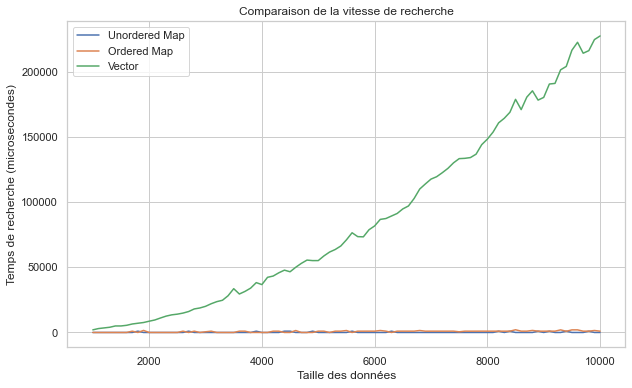

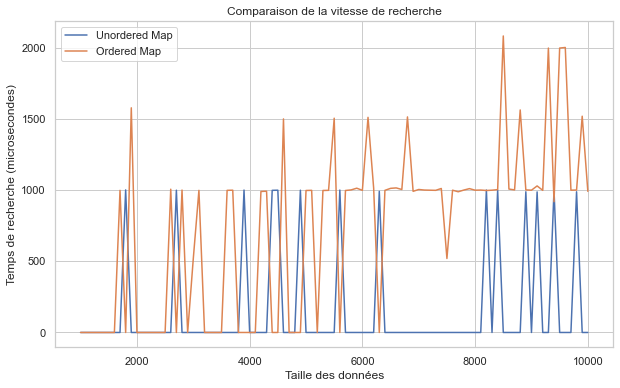

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
df = pd.read_csv('resultats.csv')

# Tracer le graphique avec Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Adapter le graphique selon les colonnes de ton fichier CSV
sns.lineplot(x='Size', y='UnorderedMapTime', data=df, label='Unordered Map')
sns.lineplot(x='Size', y='OrderedMapTime', data=df, label='Ordered Map')
sns.lineplot(x='Size', y='VectorTime', data=df, label='Vector')

plt.title('Comparaison de la vitesse de recherche')
plt.xlabel('Taille des données')
plt.ylabel('Temps de recherche (microsecondes)')
plt.legend()
plt.show()

# Afficher un autre graphique avec seulement les données de unordered_map et ordered_map
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x='Size', y='UnorderedMapTime', data=df, label='Unordered Map')
sns.lineplot(x='Size', y='OrderedMapTime', data=df, label='Ordered Map')

plt.title('Comparaison de la vitesse de recherche')
plt.xlabel('Taille des données')
plt.ylabel('Temps de recherche (microsecondes)')
plt.legend()
plt.show()


In [4]:
%%cpp
#include <iostream>
#include <fstream>
#include <unordered_map>
#include <map>
#include <vector>
#include <ctime>
#include <cstdlib>
#include <chrono>
#include <algorithm>
#include <functional>

#include <iostream>
#include <fstream>
#include <unordered_map>
#include <map>
#include <vector>
#include <ctime>
#include <cstdlib>
#include <chrono>
#include <algorithm>
#include <functional>

int main() {
    const int MIN = 1000;  // Taille min
    const int MAX = 1000000;  // Taille max
    const int PAS = 10000;  // Pas

    std::unordered_map<int, int> unorderedMap;
    std::map<int, int> orderedMap;
    std::vector<int> vector;

    // Fonction pour mesurer le temps
    auto measureTime = [](const std::function<void()>& func) {
        auto start = std::chrono::high_resolution_clock::now();
        func();
        auto end = std::chrono::high_resolution_clock::now();
        return std::chrono::duration_cast<std::chrono::microseconds>(end - start).count();
    };

    // Nom du fichier CSV
    const std::string csvFileName = "resultats2.csv";

    // Ouverture du fichier en mode écriture
    std::ofstream csvFile(csvFileName);

    // Vérification si l'ouverture a réussi
    if (!csvFile.is_open()) {
        std::cerr << "Erreur lors de l'ouverture du fichier CSV." << std::endl;
        return 1; // Quitter le programme avec un code d'erreur
    }

    // Écriture de l'en-tête du fichier CSV
    csvFile << "Size,UnorderedMapTime,OrderedMapTime,VectorTime\n";

    // Boucle pour différentes tailles de données
    for (int size = MIN; size <= MAX; size += PAS) {
        // Remplissage des structures avec des nombres aléatoires
        unorderedMap.clear();
        orderedMap.clear();
        vector.clear();

        for (int i = 0; i < size; ++i) {
            int randomNum = rand() % size;  // Nombre aléatoire dans la plage
            unorderedMap[randomNum] = i;
            orderedMap[randomNum] = i;
            vector.push_back(randomNum);
        }

        // Mesurer le temps pour la recherche dans unordered_map
        auto unorderedMapTime = measureTime([&]() {
            for (int i = 0; i < size; ++i) {
                auto it = unorderedMap.find(i);
                // Faire quelque chose avec 'it' pour éviter l'optimisation du compilateur
                if (it != unorderedMap.end()) {}
            }
        });

        // Mesurer le temps pour la recherche dans ordered_map
        auto orderedMapTime = measureTime([&]() {
            for (int i = 0; i < size; ++i) {
                auto it = orderedMap.find(i);
                // Faire quelque chose avec 'it' pour éviter l'optimisation du compilateur
                if (it != orderedMap.end()) {}
            }
        });

        // Écriture des résultats dans le fichier CSV
        csvFile << size << "," << unorderedMapTime << "," << orderedMapTime << "\n";
    }

    // Fermeture du fichier
    csvFile.close();

    return 0;
}



<Figure size 720x432 with 0 Axes>

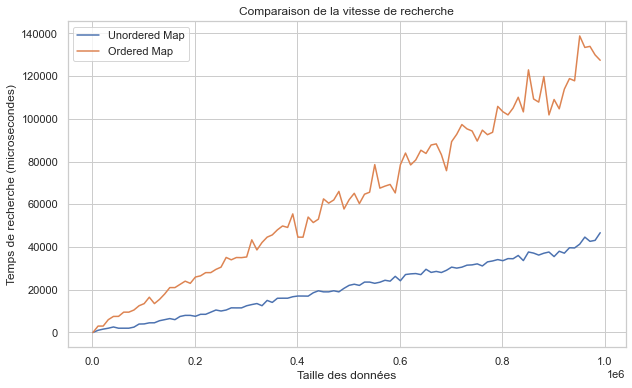

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
df = pd.read_csv('resultats2.csv')

# Tracer le graphique avec Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x='Size', y='UnorderedMapTime', data=df, label='Unordered Map')
sns.lineplot(x='Size', y='OrderedMapTime', data=df, label='Ordered Map')

plt.title('Comparaison de la vitesse de recherche')
plt.xlabel('Taille des données')
plt.ylabel('Temps de recherche (microsecondes)')
plt.legend()
plt.show()

In [6]:
# suppression des csv
import os
os.remove("resultats.csv")
os.remove("resultats2.csv")